# VAE performances

* Similarity evaluation
* Statistical evaluation
* Physical evaluation

In [1]:
# imports
from traffic.core import Traffic
from deep_traffic_generation.core.utils import extract_features

import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
features = ["latitude", "longitude", "altitude", "timedelta"]

In [3]:
t_gen = Traffic.from_file("./outputs/vae_gen.csv")
X_gen = extract_features(t_gen, features)
X_gen = X_gen.reshape(X_gen.shape[0], -1, len(features))
X_gen.shape

(1000, 200, 4)

In [4]:
t_ref = Traffic.from_file("../deep_traffic_generation/data/traffic_15.pkl")
X_ref = extract_features(t_ref, features)
X_ref = X_ref.reshape(X_ref.shape[0], -1, len(features))
X_ref.shape

(3968, 200, 4)

### Similarity Evaluation

In [7]:
from tslearn.metrics import dtw

gen_idx = 0

best_idx = None
best_distance = None

for i in range(len(X_ref)):
    distance = dtw(X_gen[gen_idx], X_ref[i])
    if best_distance is None:
        best_idx = i
        best_distance = distance
    elif best_distance > distance:
        best_distance = distance
        best_idx = i

best_distance

459.34955420915895

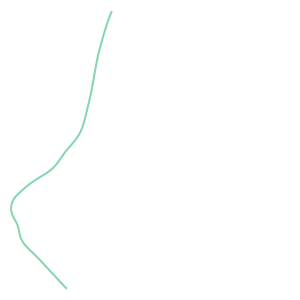

In [8]:
t_gen[gen_idx]

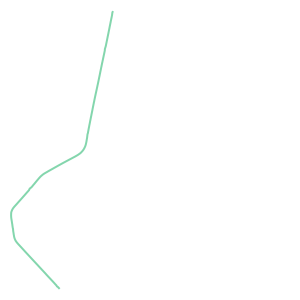

In [9]:
t_ref[best_idx]